In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

In [40]:
fname="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod_ctau-10.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [41]:
#cuts on MET and Jet
MET_mask = events.MET.pt >120
Jet_mask = events.Jet.pt.max() > 80
MET_Jet_mask = MET_mask & Jet_mask

soft_eles = events[MET_Jet_mask].ElectronBPark

matched_gen_mask = ((abs(soft_eles.matched_gen.pdgId) == 11) 
               & (soft_eles.matched_gen.parent.pdgId == 1000023)
               & (soft_eles.matched_gen.status == 1) 
               & (soft_eles.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"])))


# instead of the delta_r method I'm now using matched_gen method
matched_eles = soft_eles[(matched_gen_mask) & (soft_eles.isPF==False)]

# Note that there are two categories of unmatched electrons
#
# 1. Fake electrons
# 2. Real electrons that were produced in a jet or from pileup
# Category 1 corresponds to matched_gen == None
# Category 2 corresponds to an existing matched_gen but eg. matched_gen.parent.pdgId doesn’t equal 100023
# below I'm counting both categroies as fakes
# fill the None's with false

temp_matched_mask = matched_gen_mask.fillna(False)
unmatched_mask = (~temp_matched_mask) & (soft_eles.isPF == False)
unmatched_eles = soft_eles[unmatched_mask]

def cut_pt(electrons):
    return electrons[
        (electrons.pt<5) 
        & (electrons.pt>1)
    ]

print("The number of matched electrons with 1<pt<5 GeV:")
print(len(cut_pt(matched_eles).flatten())) #compared to 434 with ctau=1mm

The number of matched electrons with 1<pt<5 GeV:
266


In [42]:
# define gen electrons

GenPart_mask = ((abs(events[MET_Jet_mask].GenPart.pdgId) == 11) 
               & (events[MET_Jet_mask].GenPart.parent.pdgId == 1000023)
               & (events[MET_Jet_mask].GenPart.status == 1) 
               & (events[MET_Jet_mask].GenPart.hasFlags(["fromHardProcess", "isFirstCopy"])))

all_gen_eles = events[MET_Jet_mask].GenPart[GenPart_mask]
print("Number of gen eles with desired qualities: ")
print(len(all_gen_eles.flatten()))

Number of gen eles with desired qualities: 
1542


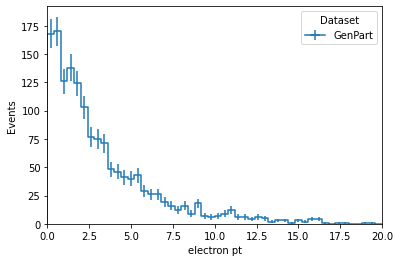

In [43]:
# masked Gen ele pt.
histo_gen_pt= hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ele_pt", "electron pt", 50, 0, 20),
        )
histo_gen_pt.fill(dataset = "GenPart", ele_pt=events[MET_Jet_mask].GenPart[GenPart_mask].pt.flatten())
hist.plot1d(histo_gen_pt)

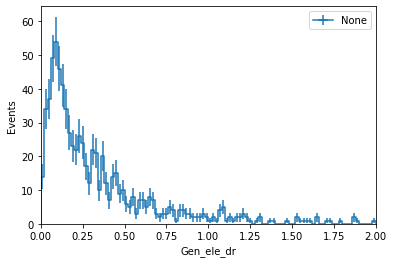

In [44]:
# masked Gen Ele dr
histo_gen_dr = hist.Hist(
            "Events",
            hist.Bin("gen_ele_dr", "Gen_ele_dr", 100, 0, 2),
        )
genEle_pairs = events[MET_Jet_mask].GenPart[GenPart_mask].distincts(nested=True)
histo_gen_dr.fill(gen_ele_dr=genEle_pairs.i0.delta_r(genEle_pairs.i1).min().flatten())
hist.plot1d(histo_gen_dr)

In [107]:
def cut2(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 2.5)
        & (electrons.ip3d > 0.02)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d < 200)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.2) # test (should it be greater than zero?)
        & (abs(electrons.dz) < 2)
         & (abs(electrons.dxy) < 1)
#         &(electrons.ptBiased > 1) #both were originally 0
         & (electrons.ptBiased > 0.5)
    ]
print("Number of matched electrons passing the ID:")
print(len(cut2(matched_eles).flatten())) #compared to 263 with ctau=1mm

Number of matched electrons passing the ID:
167


In [108]:
#
# Note that in the function below I'm counting both categories as fakes
#
import operator
# calculates the number of fakes per event
# parameter "electrons": jagged array of events
# paramter "good_cut": cut on electrons
# parameter "matched_mask": matching mask related to soft_eles
# output: returns a list containing the umber of fakes per event
def numfakes(electrons, good_cut, match_mask, pf_mask):
    x=[]
    for i in good_cut(electrons[pf_mask]):
        x.append(len(i))
    y=[]
    for i in good_cut(electrons[(match_mask) & (pf_mask)]):
        y.append(len(i))
    return list(map(operator.sub, x, y))

The avg. number of fakes per event is (with ID):
0.9459279038718291
Then avg. number of fakes per event without ID is:
41.649532710280376


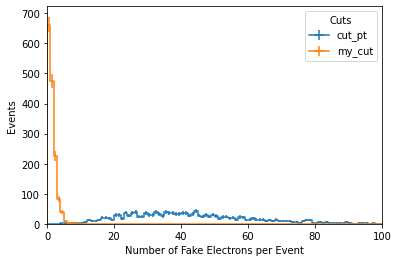

In [109]:
histo_numfakes= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False))))
histo_numfakes.fill(cuts="my_cut", numfakes = np.array(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False))))

#
# Note that when calculating the average number of fakes per event I'm also taking into account
# events with zero truth and fake electrons.
#
print("The avg. number of fakes per event is (with ID):")
print(sum(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False)))/len(numfakes(soft_eles, cut2, matched_gen_mask, (soft_eles.isPF == False))))
print("Then avg. number of fakes per event without ID is:")
print(sum(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False)))/len(numfakes(soft_eles, cut_pt, matched_gen_mask, (soft_eles.isPF == False))))
hist.plot1d(histo_numfakes)

(-0.5, 0.5)

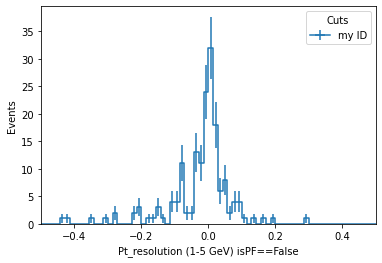

In [110]:
# pt resolution curve for 1-5 GeV

flat_eles = cut2(matched_eles).flatten()
pt_reso_cut2 = (flat_eles.pt - flat_eles.matched_gen.pt) / (flat_eles.matched_gen.pt)

histo_pt_reso = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False", 70, -0.5, 0.5),
        )
histo_pt_reso.fill(cuts = "my ID", pt_reso = np.array(pt_reso_cut2))

ax_pt_reso = hist.plot1d(histo_pt_reso, overflow = "all")
ax_pt_reso.set_xlim(right=0.5, left=-0.5)


(-0.5, 0.5)

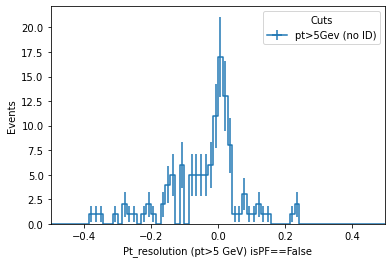

In [111]:
# pt resolution curve for pt>5 GeV, isPF==False
def cut_pt5(electrons):
    return electrons[
        (electrons.pt>5) 
    ]
flat_eles2 = cut_pt5(matched_eles).flatten()
pt_reso_cutpt5 = (flat_eles2.pt - flat_eles2.matched_gen.pt) / (flat_eles2.matched_gen.pt)

histo_pt_reso2 = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (pt>5 GeV) isPF==False", 70, -0.5, 0.5),
        )
histo_pt_reso2.fill(cuts = "pt>5Gev (no ID)", pt_reso = np.array(pt_reso_cutpt5))

ax_pt_reso2 = hist.plot1d(histo_pt_reso2, overflow = "all")
ax_pt_reso2.set_xlim(right=0.5, left=-0.5)

(-0.5, 0.5)

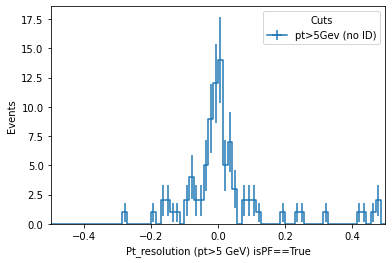

In [112]:
#pt resolution curve but with PF==True, pt>5 GeV

matched_gen_mask_pt5 = ((abs(soft_eles.matched_gen.pdgId) == 11) 
               & (soft_eles.matched_gen.parent.pdgId == 1000023)
               & (soft_eles.matched_gen.status == 1) 
               & (soft_eles.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"]))
                & (soft_eles.isPF == True))


matched_eles_pt5 = soft_eles[matched_gen_mask_pt5]

flat_eles3 = cut_pt5(matched_eles_pt5).flatten()
pt_reso_PF = (flat_eles3.pt - flat_eles3.matched_gen.pt) / (flat_eles3.matched_gen.pt)

histo_pt_reso3 = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (pt>5 GeV) isPF==True", 70, -0.5, 0.5),
        )
histo_pt_reso3.fill(cuts = "pt>5Gev (no ID)", pt_reso = np.array(pt_reso_PF))

ax_pt_reso3 = hist.plot1d(histo_pt_reso3, overflow = "all")
ax_pt_reso3.set_xlim(right=0.5, left=-0.5)

In [113]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )

histo_all.fill(variables="denominator", soft_ele = cut_pt(matched_eles).pt.flatten())

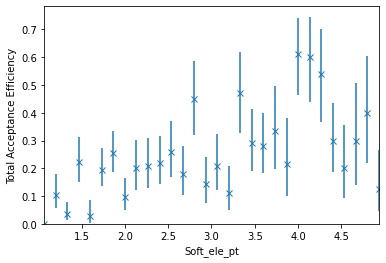

In [114]:
#total acceptance efficiency cruve
histo_all_genele = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt", 30, 1, 5),
        )
histo_eff_cut2 = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt", 30, 1, 5),
        )
histo_eff_cut2.fill(variables="looseMVA", soft_ele = cut2(matched_eles).pt.flatten())
histo_all_genele.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut2.integrate("variables"), denom=histo_all_genele.integrate("variables"), error_opts={"marker": "x"})

(-1.4, 1.4)

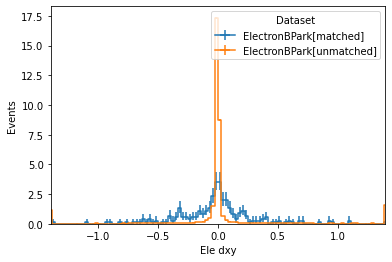

In [115]:
#guess cut: abs(1)
# there is indeed no underflow to the plot
# the overflow on the right is a gradually decreasin one, with no definitive spike
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -1.39, 1.39),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched]", dxy = cut_pt(matched_eles).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched]", dxy = cut_pt(unmatched_eles).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, density = True, overflow="all")
ax_dxy.set_xlim(right=1.4, left=-1.4)

(-20.0, 20.0)

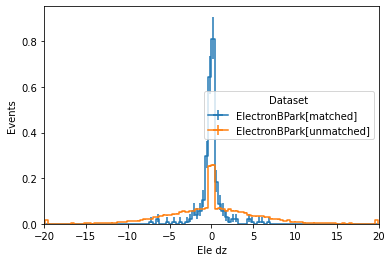

In [116]:
#guess cut: abs(5)
# there are supposed to be both overflow and underflow bins that are approximately symmetric
# it seems like overflow="all" is not working
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -19.5, 19.5),
        )
histo_dz.fill(dataset ="ElectronBPark[matched]", dz = cut_pt(matched_eles).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched]", dz = cut_pt(unmatched_eles).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow="all")
ax_dz.set_xlim(right=20, left=-20)

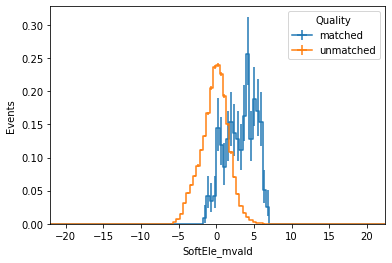

In [117]:
#The spike at 20 might be due to the two categroies of fakes, in fact it might be due to the true
# electrons that are counted as unmatched because of their  properties
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched", soft_unmatched_ele=cut_pt(matched_eles).mvaId.flatten())
histo_mvaId.fill(quality ="unmatched", soft_unmatched_ele=cut_pt(unmatched_eles).mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

(0.0, 700.0)

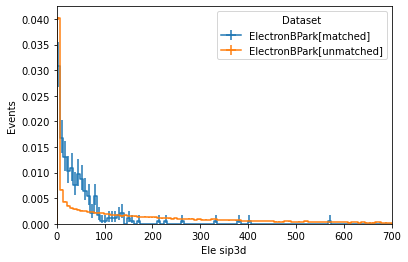

In [118]:
#guess cut: 0.2< <200
histo_sip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("sip3d", "Ele sip3d", 100, 0, 700),
        )
histo_sip3d.fill(dataset ="ElectronBPark[matched]", sip3d = cut_pt(matched_eles).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched]", sip3d = cut_pt(unmatched_eles).sip3d.flatten())
%matplotlib inline
ax_sip3d = hist.plot1d(histo_sip3d, density = True)
ax_sip3d.set_xlim(right=700
                  , left=0)

(-25.0, 25.0)

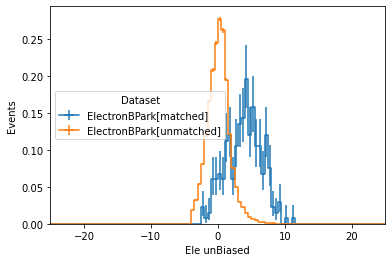

In [119]:
#guess cut: 0
histo_unBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("unBiased", "Ele unBiased", 100, -25, 25),
        )
histo_unBiased.fill(dataset ="ElectronBPark[matched]", unBiased = cut_pt(matched_eles).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched]", unBiased = cut_pt(unmatched_eles).unBiased.flatten())
%matplotlib inline
ax_unBiased = hist.plot1d(histo_unBiased, density = True, overflow="over")
ax_unBiased.set_xlim(right=25, left=-25)

(-25.0, 25.0)

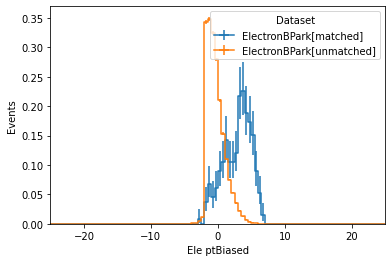

In [120]:
#guess cut:0
histo_ptBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ptBiased", "Ele ptBiased", 100, -25, 25),
        )
histo_ptBiased.fill(dataset ="ElectronBPark[matched]", ptBiased = cut_pt(matched_eles).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched]", ptBiased = cut_pt(unmatched_eles).ptBiased.flatten())
%matplotlib inline
ax_ptBiased = hist.plot1d(histo_ptBiased, density = True, overflow="over")
ax_ptBiased.set_xlim(right=25, left=-25)

(0.0, 3.0)

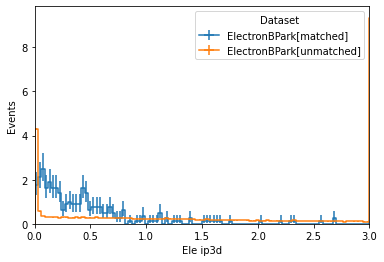

In [121]:
#guess cut: 0.02< <2.5
histo_ip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ip3d", "Ele ip3d", 100, 0, 3),
        )
histo_ip3d.fill(dataset ="ElectronBPark[matched]", ip3d = cut_pt(matched_eles).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched]", ip3d = cut_pt(unmatched_eles).ip3d.flatten())
%matplotlib inline
ax_ip3d = hist.plot1d(histo_ip3d, density = True, overflow="all")
ax_ip3d.set_xlim(right=3, left=0)

In [122]:
# #guess cut: 3 (useless)
# histo_eta = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "Dataset"),
#             hist.Bin("eta", "Ele eta", 100, -3, 3),
#         )
# histo_eta.fill(dataset ="ElectronBPark[matched]", eta = cut_pt(matched_eles).eta.flatten())
# histo_eta.fill(dataset ="ElectronBPark[unmatched]", eta = cut_pt(unmatched_eles).eta.flatten())
# %matplotlib inline
# ax_eta = hist.plot1d(histo_eta, overflow = "over", density = True)
# ax_eta.set_xlim(right=3, left=-3)
#guess cut: -----
# histo_trkRelIso = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "Dataset"),
#             hist.Bin("trkRelIso", "Ele trkRelIso", 100, 0, 6),
#         )
# histo_trkRelIso.fill(dataset ="ElectronBPark[matched]", trkRelIso = cut_pt(matched_eles).trkRelIso.flatten())
# histo_trkRelIso.fill(dataset ="ElectronBPark[unmatched]", trkRelIso = cut_pt(unmatched_eles).trkRelIso.flatten())
# %matplotlib inline
# ax_trkRelIso = hist.plot1d(histo_trkRelIso, density = True, overflow="over")
# ax_trkRelIso.set_xlim(right=6, left=0)
# histo_fBrem = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "Dataset"),
#             hist.Bin("fBrem", "Ele fBrem", 100, -1, 1.5),
#         )
# histo_fBrem.fill(dataset ="ElectronBPark[matched]", fBrem = cut_pt(matched_eles).fBrem.flatten())
# histo_fBrem.fill(dataset ="ElectronBPark[unmatched]", fBrem = cut_pt(unmatched_eles).fBrem.flatten())
# %matplotlib inline
# ax_fBrem = hist.plot1d(histo_fBrem, density = True, overflow="over")
# ax_fBrem.set_xlim(right=1.5, left=-1)
# histo_phi = hist.Hist(
#             "Events",
#             hist.Cat("dataset", "Dataset"),
#             hist.Bin("phi", "Ele phi", 100, -4, 4),
#         )
# histo_phi.fill(dataset ="ElectronBPark[matched]", phi = cut_pt(matched_eles).phi.flatten())
# histo_phi.fill(dataset ="ElectronBPark[unmatched]", phi = cut_pt(unmatched_eles).phi.flatten())
# %matplotlib inline
# ax_phi = hist.plot1d(histo_phi, density = True, overflow="over")
# ax_phi.set_xlim(right=4, left=-4)

In [123]:
#----------------------------------------------------------------------------
# ROC plots 
#----------------------------------------------------------------------------
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)

In [124]:
#------------------------------------------------------------------------
# ROC with respect to mvaID
#------------------------------------------------------------------------
roc_mva_cut= makeroc(
    sig=cut_pt(matched_eles.flatten()).mvaId,
    bkg=cut_pt(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-10, 10, 50),
    direction=-1,
)
roc_mva_cut2= makeroc(
    sig=cut2(matched_eles.flatten()).mvaId,
    bkg=cut2(unmatched_eles.flatten()).mvaId,
    binning=np.linspace(-10, 10, 50),
    direction=-1,
)

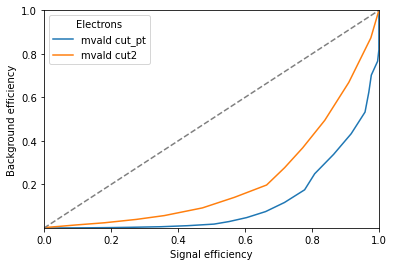

In [125]:
fig1, ax1 = plt.subplots()

ax1.plot(*roc_mva_cut, label=r"mvaId cut_pt")
# ax1.plot(*roc_mva_cut1, label=r"mvaId_cut1")
ax1.plot(*roc_mva_cut2, label=r"mvaId cut2")
diag = np.linspace(0, 1, 100)
ax1.plot(diag, diag, color='grey', linestyle='--')
ax1.set_xlabel("Signal efficiency")
ax1.set_ylabel("Background efficiency")
ax1.set_xlim(0, 1)
ax1.set_ylim(1e-3, 1)
# ax1.set_yscale('log')
ax1.legend(title=r'Electrons')

In [126]:
def cut_lowpt(electrons):
    return electrons[
        (electrons.pt<1) 
    ]

print("Number of matched eles with pt<1 GeV")
print(len(cut_lowpt(matched_eles).flatten()))

Number of matched eles with pt<1 GeV
18


In [127]:
test_matched_eles = soft_eles[(matched_gen_mask) & (soft_eles.isPF)==True]
print(len(test_matched_eles.flatten()))
print(len(matched_eles.flatten()))

173
402


In [128]:
len(events.Electron.flatten())

1764

In [129]:
len(events.ElectronBPark[events.ElectronBPark.isPF==True].flatten())

3340

In [130]:
# Relationship between mvaId and displacement
histo_mva_dz= hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ele_mvaId", "electron mvaId", 100, -10, 10),
            hist.Bin("ele_dz", "electron dz", 100, -20, 20)
        )
histo_mva_dz.fill(dataset = "soft_eles", ele_mvaId =soft_eles.mvaId.flatten(), ele_dz = soft_eles.dz.flatten())

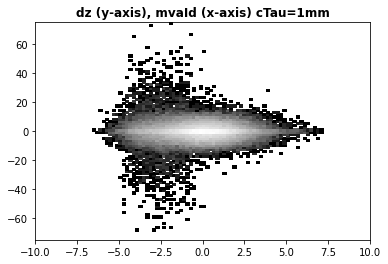

In [131]:
plt.hist2d(cut_pt(soft_eles).mvaId.flatten(), cut_pt(soft_eles).dz.flatten(), bins=100, range=[[-10, 10], [-75, 75]], norm = colors.LogNorm(),  
           cmap ="gray")
plt.title("dz (y-axis), mvaId (x-axis) cTau=1mm", fontweight ="bold") 
plt.show()

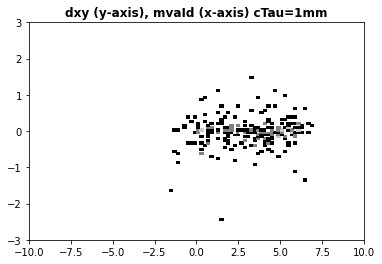

In [132]:
plt.hist2d(cut_pt(matched_eles).mvaId.flatten(), cut_pt(matched_eles).dxy.flatten(), bins=100, range=[[-10, 10], [-3, 3]], norm = colors.LogNorm(),  
           cmap ="gray")
plt.title("dxy (y-axis), mvaId (x-axis) cTau=1mm", fontweight ="bold") 
plt.show()

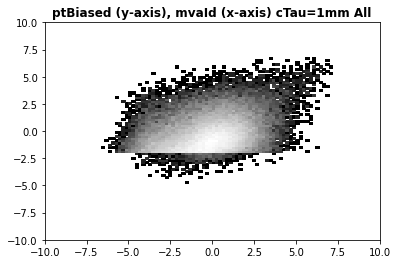

In [133]:
plt.hist2d(cut_pt(soft_eles).mvaId.flatten(), cut_pt(soft_eles).ptBiased.flatten(), bins=100, range=[[-10, 10], [-10, 10]], norm = colors.LogNorm(),  
           cmap ="gray")
plt.title("ptBiased (y-axis), mvaId (x-axis) cTau=1mm All", fontweight ="bold") 
plt.show()

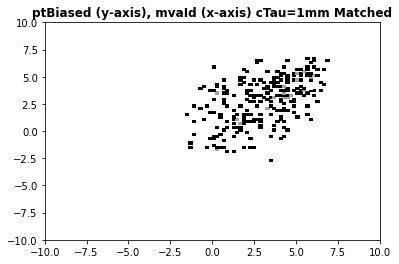

In [134]:
plt.hist2d(cut_pt(matched_eles).mvaId.flatten(), cut_pt(matched_eles).ptBiased.flatten(), bins=100, range=[[-10, 10], [-10, 10]], norm = colors.LogNorm(),  
           cmap ="gray")
plt.title("ptBiased (y-axis), mvaId (x-axis) cTau=1mm Matched", fontweight ="bold") 
plt.show()

In [135]:
print(len(events.Electron[~events.Electron.isPFcand].flatten()))
print(len(events.Electron.flatten()))
events.Electron[~events.Electron.isPFcand].flatten()

746
1764


<ElectronArray [<Electron 0> <Electron 1> <Electron 3> ... <Electron 1758> <Electron 1760> <Electron 1761>] at 0x7f23bab020a0>

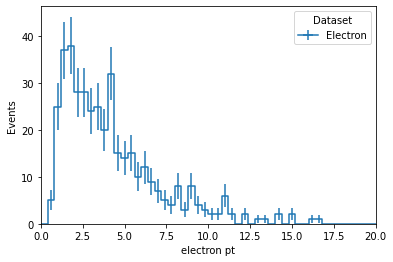

In [136]:

histo_pt= hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ele_pt", "electron pt", 50, 0, 20),
        )
histo_pt.fill(dataset = "Electron", ele_pt=matched_eles[matched_eles.isLowPt].pt.flatten())
hist.plot1d(histo_pt)

(-2.5, 1.5)

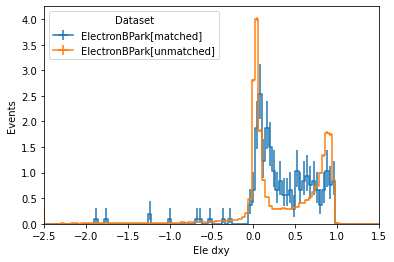

In [137]:
# guess cut > -1.9
histo_fBrem = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -2.5, 1.5),
        )
histo_fBrem.fill(dataset ="ElectronBPark[matched]", dxy = cut_pt(matched_eles).fBrem.flatten())
histo_fBrem.fill(dataset ="ElectronBPark[unmatched]", dxy = cut_pt(unmatched_eles).fBrem.flatten())
%matplotlib inline
ax_fBrem = hist.plot1d(histo_fBrem, density = True, overflow="all")
ax_fBrem.set_xlim(right=1.5, left=-2.5)

In [144]:
soft_eles.matched_gen.status?